# Mesh 3

Menys slope que la mesh1

Density function in `refinter.f90`

    real (r8) function densf(x) result(dens_f)
        real (r8), dimension(1:2), intent(in) :: x
        real (r8), dimension(1:3) :: p
        real (r8) :: lat
        real (r8) :: lon
        real (r8) :: latc
        real (r8) :: lonc
        real (r8) :: radiuse
        real (r8) :: slope
        real (r8) :: epsilons
        real (r8) :: dists
        real (r8) :: maxdist
        real (r8) :: sx

        !Density function parameters
        ! (increase_of_resolution) / (distance)
        slope = 10._r8/600._r8
        ! radius (in km) of high resolution area
        maxdist = 50._r8
        ! distance (in km) of transition zone belt: ratio / slope
        epsilons = 150._r8/slope
        if(epsilons > 10000._r8)then
            epsilons = 10000._r8
        end if

        ! x is the input; the function is called like densf([lat, lon])
        lat = x(1)
        lon = x(2)

        !Center of refined region is 0,-8.4559 in radians (center of pentagon)
        ! TODO cannot do latc=-8.4559
        latc=0._r8
        lonc=0._r8
        !Distance to center ()
        radiuse = 6367._r8
        dists = radiuse * 2 * dasin(dsqrt(dsin((latc - lat) / 2._r8)**2 + dcos(lat) * dcos(latc) * dsin ((lonc-lon) / 2._r8)**2))

        !Distance to center metric
        sx=(dists-maxdist)*slope

        !Set density
        if(dists<=maxdist)then
            !Point close to the center
            dens_f=1.0
        elseif((dists<=maxdist+epsilons) .and. (dists>maxdist))then
            !Point in the transition
            dens_f=1.0 + sx
        else
            !Point far from the center
            dens_f=1.0 + epsilons*slope
        end if

        !Normalization - Make it in [0,1]
        dens_f = 1.0 / dens_f**2
    end function densf


In [1]:
import numpy as np
import matplotlib.pyplot as plt

name_test = 'mesh2'

args_mesh = {'mesh2': {
    'slope': 10./600,
    'gammas': 150.,
    'maxdist': 50.,
    'maxepsilons': 10000.
}}

# ----------------------------------
# converts degrees to radians
deg2rad = np.pi / 180.0
# ----------------------------------
# converts degrees to radians
rad2deg = 1.0 / deg2rad

def density_function_dists(dists, slope=None, gammas=None, maxdist=None,
                           maxepsilons=None):

    epsilons = gammas/slope
    if epsilons > maxepsilons:
        epsilons = maxepsilons

    # initialize with density = 1
    dens_f = np.ones(np.shape(dists))

    # point in transition zone
    transition_zone = (dists > maxdist) & (dists <= maxdist + epsilons)
    sx = (dists-maxdist)*slope
    transition_values = 1.0 + sx
    dens_f = np.where(transition_zone, transition_values, dens_f)

    # further points
    far_from_center = (dists > maxdist + epsilons)
    dens_f[far_from_center] += epsilons*slope

    dens_f = 1 / dens_f**2
    return dens_f

def latlon_to_distance_center(lat, lon):
    lat, lon = map(np.radians, [lat, lon])

    haver_formula = np.sin(lat / 2.0) ** 2 + \
                    np.cos(lat) * np.sin(lon / 2.0) ** 2

    dists = 2 * np.arcsin(np.sqrt(haver_formula)) * 6367
    return dists

def density_function(lat, lon, **kwargs):
    dists = latlon_to_distance_center(lat, lon)

    dens_f = density_function_dists(dists, **kwargs)
    return dens_f


Needed cells for lower resolution 1km
72407.98856154915
Number smaller than 15km
65657


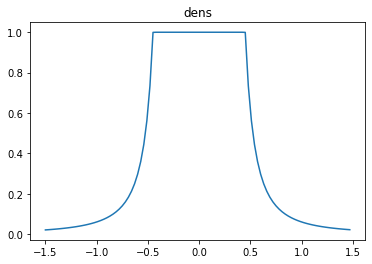

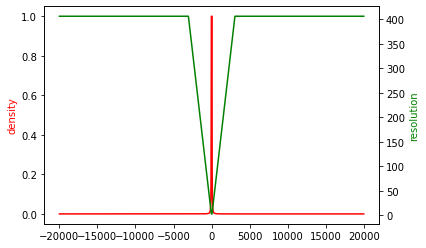

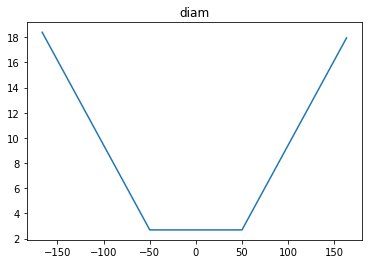

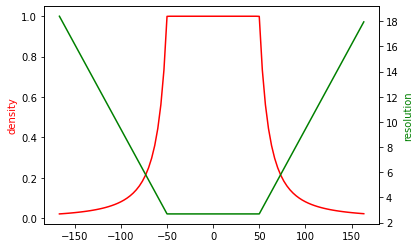

In [2]:
def density_to_resolution(dens, area, N=200000):
    sum_dens = dens.sum()
    cells_by_point = dens*N/sum_dens
    area_cells = area/cells_by_point
    res = 2*np.sqrt(area_cells/np.pi)
    return res

def areas(lon, lat, step=0.1):
    area1 = (step*110)**2*abs(np.cos(np.radians(lat)))
    area = np.tile(area1, (lon.shape[0], 1)).transpose()
    return area

def dens2res(N_cells, step=0.01, plot=True, **kwargs):
    
    lats0 = np.arange(-90.0, 90.0, step)
    lons0 = np.arange(-180.0, 180.0, step)

    lons, lats = np.meshgrid(lons0, lats0)

    area = areas(lons0, lats0, step=step)

    dens = density_function(lats, lons, **kwargs)
    
    sum_dens = dens.sum()
    
    # old method
    neededNcells = (2*110*step)**2/np.pi * sum_dens
    
    print('Needed cells for lower resolution 1km')
    print(neededNcells)
    
    resolution_cells = density_to_resolution(dens, area, N=N_cells)
    
    print('Number smaller than 15km')
    print((resolution_cells < 15.0).sum())

    if plot:
        rangedens= dens[len(lats0)//2, len(lons0)//2-50:len(lons0)//2+50]
        plt.plot(lons0[len(lons0)//2-50:len(lons0)//2+50], rangedens)
        plt.title("dens")
        plt.show()
        plt.close()
        
        dists = lons0*111

        plt.plot(dists, dens[len(lats0)//2,:], 'red')
        plt.ylabel('density')
        plt.gca().yaxis.label.set_color('red')
        ax2 = plt.gca().twinx()
        ax2.plot(dists, resolution_cells[len(lats0)//2,:], 'green')
        ax2.yaxis.label.set_color('green')
        ax2.set_ylabel('resolution')
        plt.show()
        plt.close()

        rangedists = dists[len(lons0)//2-50:len(lons0)//2+50]
        rangeres= resolution_cells[len(lats0)//2, len(lons0)//2-50:len(lons0)//2+50]
        
        plt.plot(rangedists, rangeres)
        plt.title("diam")
        plt.show()
        plt.close()
        
        plt.plot(rangedists, rangedens, 'red')
        plt.gca().yaxis.label.set_color('red')
        plt.ylabel('density')
        ax2 = plt.gca().twinx()
        ax2.plot(rangedists, rangeres, 'green')
        ax2.yaxis.label.set_color('green')
        ax2.set_ylabel('resolution')
        plt.show()
        plt.close()
        
    return resolution_cells

res = dens2res(10000, step=0.03, **args_mesh[name_test])

In [3]:
import xarray as xr
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import math
import numpy as np
import os

def read_reduced_grid(file, erase=False):
    if erase:
        os.system('rm -rf ' + file + '-reduced')

    if not os.path.exists(file + '-reduced'):
        grid = xr.open_dataset(file)

        area = grid['areaCell']
        if 'units' not in area.attrs:
            print('Rescale area to the Earth Sphere')
            area = area * (6371000)**2
            area['units'] = 'm^2'
        area.attrs['long_name'] = 'Area of the cell in m^2'
        area = area.rename('area')

        resolution = 2*(xr.apply_ufunc(np.sqrt, area/math.pi))*10**(-3)
        resolution = resolution.rename('resolution')
        resolution.attrs['long_name'] = 'Resolution of the cell (approx)'
        resolution.attrs['units'] = 'km'

        lats = grid['latCell']*180/math.pi
        lats = lats.rename('latitude')
        lats.attrs['long_name'] = 'Latitude Cell'
        lats.attrs['units'] = 'degrees'

        lons = grid['lonCell']*180/math.pi
        for i in range(len(lons)):
            if lons[i] > 180.0:
                lons[i] = lons[i] - 360.0
        lons = lons.rename('longitude')
        lons.attrs['long_name'] = 'Longitude Cell'
        lons.attrs['units'] = 'degrees'

        distance_to_center = latlon_to_distance_center(lats, lons)
        distance_to_center = distance_to_center.rename('distance')
        distance_to_center.attrs['long_name'] = 'Distance in km to (0, 0)'
        distance_to_center.attrs['units'] = 'km'

        reduced = xr.merge((lons, lats, area, resolution, distance_to_center))
        reduced.to_netcdf(file + '-reduced')
    else:
        reduced = xr.open_dataset(file + '-reduced')
    return reduced


def plot_var_mpas(data, var, outfile=None, title=''):
    if outfile is None or not os.path.exists(outfile):
        palette = "cubehelix_r"
        num = data[var].count()
        sns.scatterplot(x='longitude', y='latitude', linewidth=0,
                        hue=var, data=data, palette=palette)
        title = title  + '\nNumber Cells ' + str(num)
        plt.gca().set_aspect('equal')
        plt.legend()
        plt.title(title)
        if outfile is not None:
            plt.savefig(outfile)
        else:
            plt.show()
        plt.close()


def plot_var_mpas_crss(data, var, file=None, show=False,
                       title='', palette="Spectral_r", ax=None, **kwargs):

    if ax is None:
        ax = plt.axes(projection=ccrs.PlateCarree())

    ax.set_extent([float(data['longitude'].min()),
                   float(data['longitude'].max()),
                   float(data['latitude'].min()),
                   float(data['latitude'].max())])

    ax.coastlines()
    ax.stock_img()

    sns.scatterplot(x='longitude', y='latitude', linewidth=0,
                    hue=var, data=data, legend='brief',
                    palette=palette, ax=ax, **kwargs)

    # We have to set the map's options on all axes
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax.set_title(title, fontsize=10)
    if file is not None:
        plt.savefig(file)
    if show:
        plt.show()
    return


def twoplots(ds, var, limres=15, show=True, file=None, figsize=None, hue_norm=None):

    smallds = ds.where(ds['resolution'] < limres)

    try:
        ln = ds[var].attrs['long_name']
        print(ln)
    except:
        ln = ''

    if hue_norm is None:
        hue_norm = (float(ds[var].min()), float(ds[var].max()))

    fig, axs = plt.subplots(1, 2, subplot_kw={'projection': ccrs.PlateCarree()})
    plot_var_mpas_crss(ds, var, ax=axs[0], size='area', hue_norm=hue_norm)
    plot_var_mpas_crss(smallds, var, ax=axs[1], size='area', hue_norm=hue_norm,
                       title='Smaller cells (< 15km res.)')
    if figsize is None:
        figsize = [10, 5]
    fig.set_size_inches(figsize)
    if file is not None:
        plt.savefig(file)
    if show:
        plt.show()
    plt.close()

In [4]:
def study_mesh(file):
    reduced = read_reduced_grid(file, erase=True)

    for v in ['area', 'resolution']:
        vals = np.sort(reduced[v].values)
        plt.plot(vals)
        plt.yscale('log')
        plt.ylabel(v)
        plt.title(reduced[v].attrs['long_name'])
        plt.show()
        plt.close()

    print('Number smaller than 15km: ')
    print(float((reduced['resolution'] < 15.0).sum()))

    twoplots(reduced, 'resolution', limres=15, figsize=[13, 5])

    print('Different Radius')
    for lim in [50, 100, 150, 200]:
        small = reduced.where(reduced['distance'] < lim)
        plot_var_mpas_crss(small, 'resolution', show=True,
                           title='Closer than %.1fkm' % lim)

    print('Different highest resolution')
    for limit in [3.0, 5.0, 10.0, 15.0, 30.0]:
        try:
            good = reduced.where(reduced['resolution'] < limit)
            plot_var_mpas_crss(good, 'resolution', show=True,
                               title='Resolution lower than %.1fkm' % limit)
        except:
            plt.close()
            print('No cells with resolution lower than %.1fkm' % limit)

    plot_resolution_area_sns(reduced.where(reduced['distance'] < 300))


def plot_resolution_area(ds):
    relation = ds.groupby_bins('distance', bins=5000).mean()
    rangedists = relation['distance_bins'].values
    dists = [float(x.mid) for x in rangedists]
    area = relation['area'].values
    resolution_cells = relation['resolution'].values

    plt.plot(dists, area, 'blue')
    plt.ylabel('area')
    plt.gca().yaxis.label.set_color('blue')
    ax2 = plt.gca().twinx()
    ax2.plot(dists, resolution_cells, 'green')
    ax2.yaxis.label.set_color('green')
    ax2.set_ylabel('resolution')
    plt.show()
    plt.close()

    return

def plot_resolution_area_sns(ds, rounded=10):
    pds = ds.to_dataframe().dropna()
    pds['round_dist'] = rounded*((pds['distance']/rounded).astype('int')) + rounded/2
    sns.lineplot(data=pds, x='round_dist', y='resolution')
    plt.show()
    plt.close()

    return


test_meshes/mesh2/meshes/mesh2-lev4_grid.nc
Rescale area to the Earth Sphere


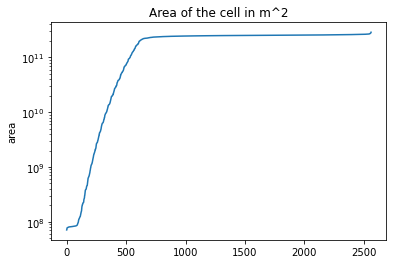

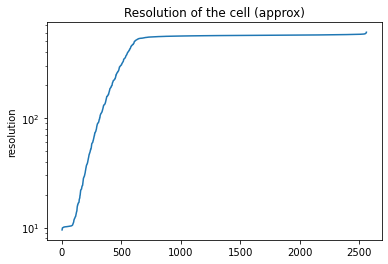

Number smaller than 15km: 
128.0
Resolution of the cell (approx)


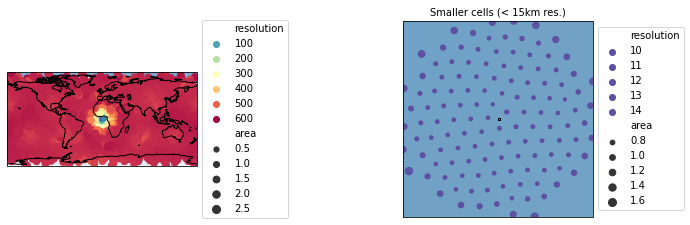

Different Radius


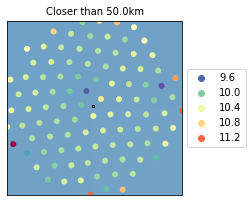

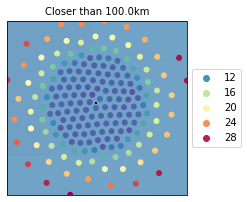

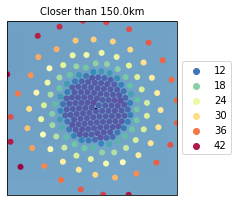

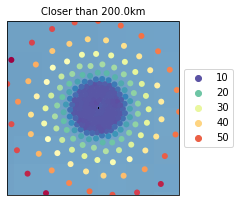

Different highest resolution
No cells with resolution lower than 3.0km
No cells with resolution lower than 5.0km


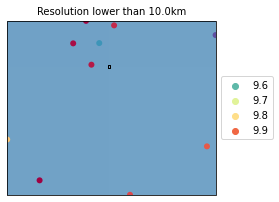

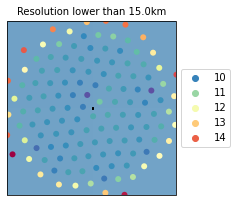

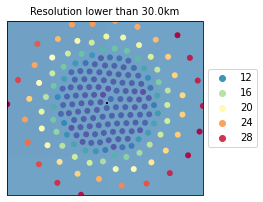

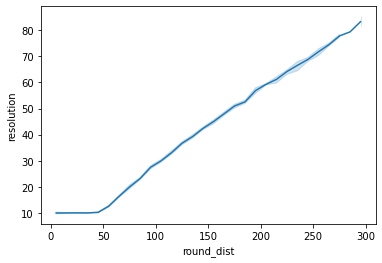

In [5]:
import glob

files = sorted(glob.glob('test_meshes/' + name_test + '/meshes/*_grid.nc'))

for file in files:
    print(file)
    study_mesh(file)